# GrabCut Foreground Extraction

**Goal**: Learn how to use **GrabCut** for foreground extraction with minimal user interaction.

## 목차
1. **이론**: GrabCut 알고리즘 (GMM, Graph Cut, Iteration)
2. **Colab 준비** (라이브러리 설치, 이미지 준비)
3. **사각형 모드** 예시: (cv.GC_INIT_WITH_RECT)
4. **마스크 모드** 예시: (cv.GC_INIT_WITH_MASK, 수정 마스크 반영)
5. **과제** (인터랙티브 툴, 파라미터 변경 등)
6. **Q&A**


# 1. 이론: GrabCut
1. **사용자가** 초기 정보 제공
   - 사각형으로 대략적 전경 지정 **or** 전경/배경 픽셀(마스크) 직접 지정.
2. **GMM(Gaussian Mixture Model)**로 전경, 배경의 색 분포 추정.
3. **Graph**를 구성해 mincut(=에너지 최적화)으로 전경/배경을 분리.
4. 결과가 만족스럽지 않으면, 사용자 **수정**(전경으로 확실히 하고픈 곳 → cv.GC_FGD, 배경으로 확실히 하고픈 곳 → cv.GC_BGD) 후 다시 Iteration.

### OpenCV 함수: `cv.grabCut`
```python
cv.grabCut(
    img,         # uint8, 3-채널(BGR)
    mask,        # 0=BGD, 1=FGD, 2=PR_BGD, 3=PR_FGD
    rect,        # x,y,w,h or None
    bgdModel,    # np.float64 (1,65)
    fgdModel,    # np.float64 (1,65)
    iterCount,   # 반복 횟수
    mode         # cv.GC_INIT_WITH_RECT or cv.GC_INIT_WITH_MASK
)
```
- **mask**: 결과로 배경/전경 확정(0,1) & 추정(2,3)를 담음.
- **rect**: 초기 전경 사각형 (mode = `cv.GC_INIT_WITH_RECT`)
- **bgdModel**, **fgdModel**: 내부 모델용 배열(초기엔 0)
- **iterCount**: 반복 횟수
- **mode**: 사각형 모드 or 마스크 모드


# 2. Colab 준비: 라이브러리 설치 & 이미지 준비

In [ ]:
!pip install opencv-python numpy matplotlib --quiet
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
print("OpenCV version:", cv.__version__)

OpenCV version: 4.10.0


아래 셀은 예시 이미지(`messi5.jpg`)를 다운로드하거나, 사용자 이미지를 업로드 후 경로 수정해서 사용할 수 있습니다.

In [ ]:
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/data/messi5.jpg -O messi5.jpg
import os
if not os.path.exists('messi5.jpg'):
    print("messi5.jpg download failed. Please upload another image or change file name.")
else:
    print("messi5.jpg downloaded.")

messi5.jpg downloaded.


# 3. 사각형 모드 예시 (cv.GC_INIT_WITH_RECT)
1. 사각형(rect)을 그레이 수준으로 대충 전경 감싸도록 지정
2. grabCut(iter=5)
3. mask에서 0,2 → 배경(0), 1,3 → 전경(1)으로 변환
4. 최종 (img * mask2)로 마스킹.


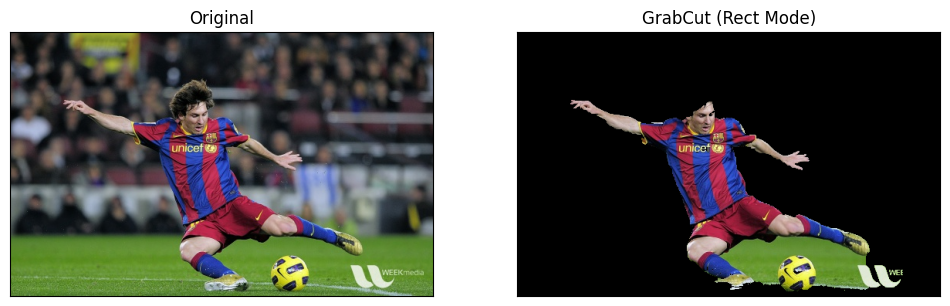

In [ ]:
img_path = 'messi5.jpg'
img = cv.imread(img_path)
if img is None:
    raise FileNotFoundError("Image not found.")

mask = np.zeros(img.shape[:2], np.uint8)

bgdModel = np.zeros((1,65), np.float64)
fgdModel = np.zeros((1,65), np.float64)

# rect: x,y,w,h
rect = (50,50,450,290)  # this rect should include entire foreground

cv.grabCut(
    img, mask, rect, bgdModel, fgdModel,
    5, mode=cv.GC_INIT_WITH_RECT
)

# mask == 0 or 2 => background, mask == 1 or 3 => foreground
mask2 = np.where(
    (mask==2) | (mask==0),
    0,
    1
).astype('uint8')

result = img * mask2[:,:,np.newaxis]

# 시각화
plt.figure(figsize=(12,5))
plt.subplot(1,2,1), plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.title('GrabCut (Rect Mode)'), plt.xticks([]), plt.yticks([])
plt.show()

이 경우, 세부적으로 일부 foreground가 누락되거나, 일부 배경이 포함될 수 있습니다.
이를 **마스크 수정**(수동)한 뒤, 다시 grabCut(iter, mode=cv.GC_INIT_WITH_MASK)로 개선할 수 있습니다.

# 4. 마스크 모드 예시 (cv.GC_INIT_WITH_MASK)
1. 사용자(또는 paint/Photoshop 등)로 전경(흰색=255) / 배경(검정=0) 레이블만 칠한 **newmask**.
2. newmask.png 를 load → `mask`에 반영.
3. grabCut(iter=5, mode=cv.GC_INIT_WITH_MASK).
4. 결과 확인.

아래 코드는 예시. 실제 Colab에서는 paint로 수정한 마스크를 업로드하거나, 수동으로 array를 생성해서 시도할 수도 있습니다.

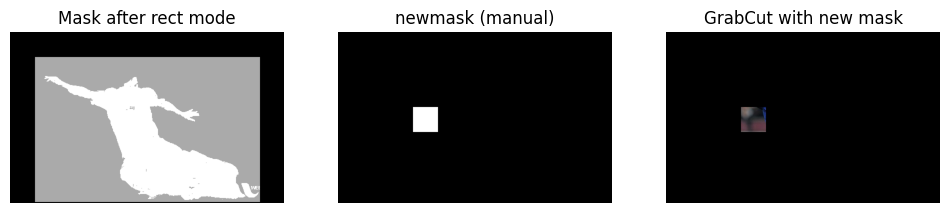

In [ ]:
# For demonstration, let's create a mock newmask using simple rectangle or something.
# Ideally, you'd upload 'newmask.png' (0=BG,255=FG) or more subtle.

mask_custom = mask.copy()

# E.g., let's say we forcibly define top-left corner as background (0)
mask_custom[0:100, 0:100] = 0  # sure BG
# forcibly define some region as FG(1). Actually in grabCut convention: 0=BG,1=FG,2=PR_BGD,3=PR_FGD.
# But for direct mask approach: we do 0=BG,255=FG, etc.
# We'll do a simple approach: if newmask=0 => BG, if newmask=255 => FG.

# Let's create a fake newmask for demonstration:
newmask = np.zeros_like(mask)
newmask[150:200, 150:200] = 255  # some region forced FG

mask_custom[newmask==0] = 0  # sure background
mask_custom[newmask==255] = 1 # sure foreground

# Now run grabCut in mask mode
bgdModel2 = np.zeros((1,65), np.float64)
fgdModel2 = np.zeros((1,65), np.float64)

cv.grabCut(
    img, mask_custom,
    None,
    bgdModel2, fgdModel2,
    5,
    mode=cv.GC_INIT_WITH_MASK
)

mask2 = np.where(
    (mask_custom==2)|(mask_custom==0),
    0, 1
).astype('uint8')

result2 = img * mask2[:,:,np.newaxis]

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(mask, cmap='gray')
plt.title('Mask after rect mode')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(newmask, cmap='gray')
plt.title('newmask (manual)')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(cv.cvtColor(result2, cv.COLOR_BGR2RGB))
plt.title('GrabCut with new mask')
plt.axis('off')
plt.show()

# 5. 과제
1. **사각형 모드**만으로는 세밀 조정이 어려움. 실제 이미지에서 상호작용 방식으로 **마우스로 드래그**(로컬 Python)하여 rect 지정, grabCut 후, 부분적으로 마스크 수정.
2. **mask** 수정 시, 0( sure BG ), 1( sure FG ), 2( probable BG ), 3( probable FG ) 등을 다양하게 설정해 본다.
3. **파라미터** (iterCount) 바꿔서 결과를 비교.
4. **다른 이미지**(배경과 비슷한 색의 전경)로 GrabCut 시 어떤 결과?
5. **배경만 분리**(img - result) 등으로 예술적인 효과를 시도.


# Q&A
- **Q**: GrabCut과 일반적인 Threshold-based 방법 차이?
  - **A**: GrabCut은 **색 분포(GMM)**와 **graph cut**을 통해 여러 Iteration으로 정교하게 전경/배경 분리. 임계값 하나로 결정하는 방식보다 **복잡한 배경**에도 대응.
- **Q**: 사각형 모드 후, 잡히지 않은 부분이 있을 때?
  - **A**: **마스크 모드**로 전환, 수동(또는 paint)으로 특정 영역을 전경/배경 지정 후 다시 grabCut.
- **Q**: Iteration을 많이 하면 무조건 좋나?
  - **A**: 보통 5~10번이면 수렴. 너무 많아도 크게 변동 없거나, 시간만 소요.

이상으로 **GrabCut** 알고리즘을 Colab에서 간단히 실습했습니다.
실제 프로젝트에서는 로컬 환경에서 **마우스 이벤트**로 상호작용하면 더욱 편리합니다!